# Results for experiments with Co-embeddings

In [1]:
%matplotlib inline
import numpy
import pandas
import pickle
import os
import re

from sklearn import metrics

In [2]:
import seaborn
seaborn.set_style('white')

In [3]:
def get_runs(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'prediction' in run_prediction]

def get_learning(dirname):
    return [run_prediction for run_prediction in os.listdir(dirname)
            if os.path.isfile(os.path.join(dirname, run_prediction)) and 'performance' in run_prediction]

In [4]:
def base_metrics_df():
    return pandas.DataFrame(columns=['Experiment', 'Run',
                                     'AUC-mean', 'RMSE-mean', 'APS-mean', 'Accuracy-mean', 'R2-mean',
                                     'AUC-std', 'RMSE-std', 'APS-std', 'Accuracy-std', 'R2-std'])

In [5]:
def get_not_averaged_metrics(dirnames):
    """Returns the metrics not averaged by student sequence"""
    results = []
    for dirname in reversed(dirnames):
        for filename in get_runs(dirname):
            results.append([dirname.split('/')[-2]])
            results[-1].append(re.search('.*run(\d+).*', filename).group(1))
            with open(os.path.join(dirname, filename), 'rb') as prediction_file:
                true, predicted = pickle.load(prediction_file)

            # Flatten the sequences
            true_sequence = numpy.array([x for sequence in true for x in sequence])
            predicted_sequence = numpy.array([x for sequence in predicted for x in sequence])

            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
            results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
            results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
            results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
            results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))

    return pandas.DataFrame(results, columns=['Experiment', 'Run', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

## Learning curves

In [6]:
def read_performances(dirnames):
    results = {}
    for dirname in reversed(dirnames):
        dataframes = []
        for filename in get_learning(dirname):
            with open(os.path.join(dirname, filename), 'rb') as performance_file:
                train, validation = pickle.load(performance_file)
            train = pandas.DataFrame(train, columns=['epoch', 'mse'])
            validation = pandas.DataFrame(validation, columns=['epoch', 'mse'])
            train['Dataset'] = 'train'
            train['Run'] = re.search('.*run(\d+).*', filename).group(1)
            validation['Dataset'] = 'validation'
            validation['Run'] = re.search('.*run(\d+).*', filename).group(1)
            dataframes.append(pandas.concat([train, validation]))
        if len(dataframes) > 0:
            results[dirname] = pandas.concat(dataframes) # train.join(validation, lsuffix='_t', rsuffix='_v')
    return results

def graphic_performances(train_performances):
    for dirname, performance_dataframe in train_performances.items():
        print(dirname)
        grid = seaborn.FacetGrid(data=performance_dataframe,
                                 col='Run', despine=True, ylim=[0, 0.3], aspect=1.5, col_wrap=2,
                                 palette='colorblind')
        grid.map(seaborn.pointplot, 'epoch', 'mse', 'Dataset').add_legend()

# Experiments with EMBEDDINGS

In [13]:
EMBEDDINGS_EXPERIMENTS_DIRS = [
    # Previous files use 2017 script.
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-21-19-21/',
]

In [14]:
embedding_performances = read_performances(EMBEDDINGS_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/dkt_lstm/by_problem_id/embeddings/18-02-21-19-21/


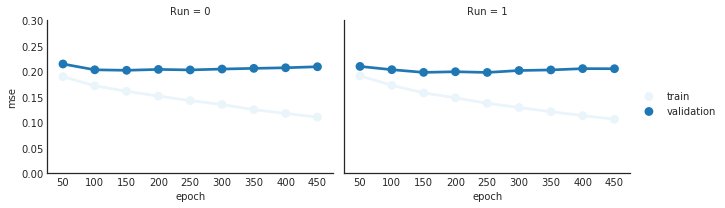

In [15]:
graphic_performances(embedding_performances)

## Performance metrics not averaged by sequence

In [16]:
embedding_not_averaged_results = get_not_averaged_metrics(EMBEDDINGS_EXPERIMENTS_DIRS)
embedding_not_averaged_results.groupby('Experiment').mean()

,AUC,RMSE,APS,Accuracy,R2
Experiment,,,,,
18-02-21-19-21,0.737048,0.453635,0.834349,0.702801,0.094009


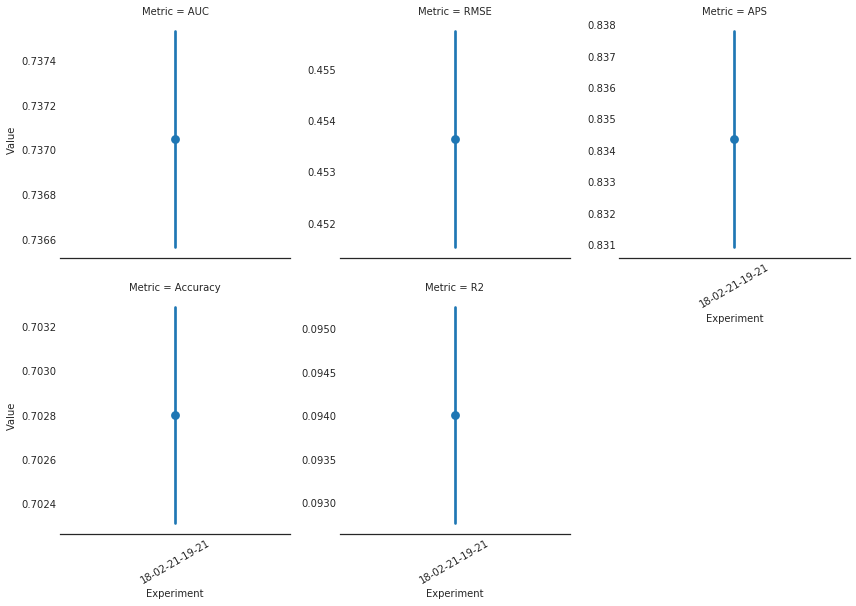

In [17]:
g = seaborn.factorplot(
    data=embedding_not_averaged_results.set_index(['Experiment', 'Run']).stack().reset_index().rename(
        columns={'level_2': 'Metric', 0: 'Value'}), x='Experiment', y='Value', col='Metric', sharey=False,
    col_wrap=3, join=False)
g.set_xticklabels(rotation=30)
seaborn.despine(left=True)

# Experiments with COEMBEDDINGS

In [7]:
COEMBEDDINGS_EXPERIMENTS_DIRS = [
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-17-09/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-18-44/',
    '/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-18-45/',
]

In [8]:
performances = read_performances(COEMBEDDINGS_EXPERIMENTS_DIRS)

/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-18-45/
/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-18-44/
/home/mteruel/edm/results/dkt_lstm/by_problem_id/coembeddings/18-02-21-17-09/


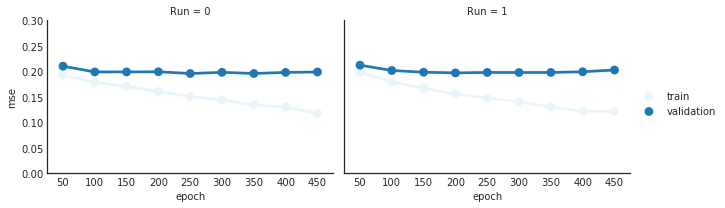

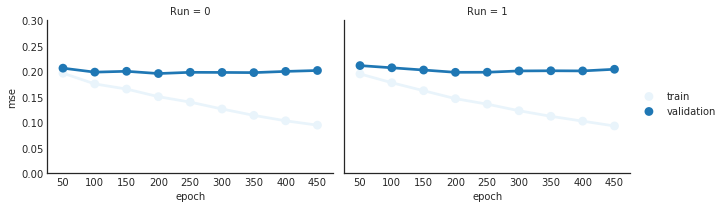

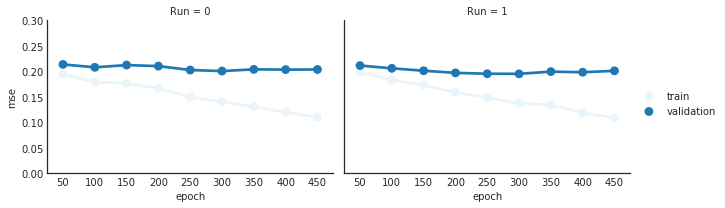

In [9]:
graphic_performances(performances)

## Performance metrics not averaged by sequence

In [11]:
not_averaged_results = get_not_averaged_metrics(COEMBEDDINGS_EXPERIMENTS_DIRS)
not_averaged_results.groupby('Experiment').mean()

,AUC,RMSE,APS,Accuracy,R2
Experiment,,,,,
18-02-21-17-09,0.727600,0.455321,0.831263,0.696181,0.085394
18-02-21-18-44,0.731607,0.456022,0.834522,0.701569,0.079310
18-02-21-18-45,0.736129,0.451456,0.836386,0.701623,0.101752


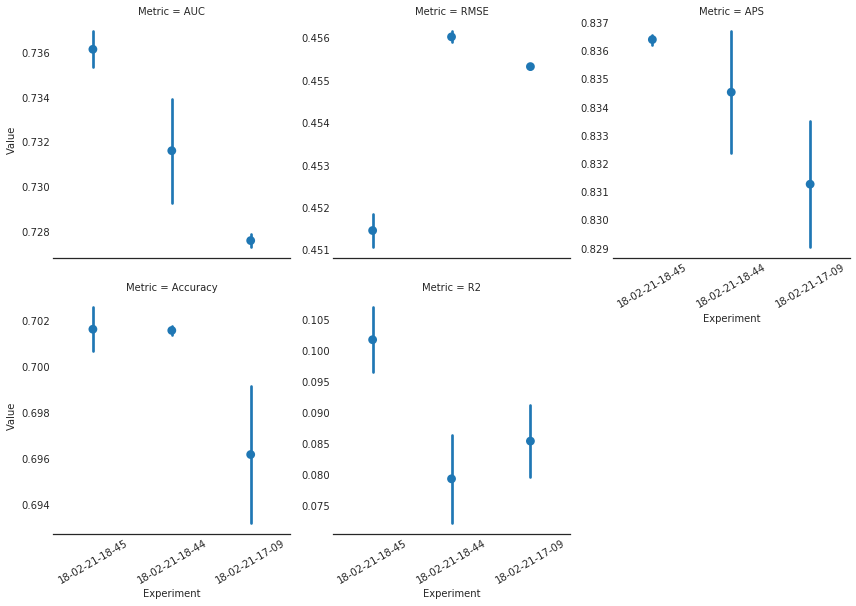

In [12]:
g = seaborn.factorplot(
    data=not_averaged_results.set_index(['Experiment', 'Run']).stack().reset_index().rename(
        columns={'level_2': 'Metric', 0: 'Value'}), x='Experiment', y='Value', col='Metric', sharey=False,
    col_wrap=3, join=False)
g.set_xticklabels(rotation=30)
seaborn.despine(left=True)

## Performance Metrics by sequence

In [15]:
def read_file_metrics(filename):
    """Returns a DataFrame with values Sequence length, AUC, RMSE, APS, Accuracy, R2 Score"""
    results = []
    ignored_sequences = 0
    with open(filename, 'rb') as prediction_file:
        true, predicted = pickle.load(prediction_file)
    for true_sequence, predicted_sequence in zip(true, predicted):
        if true_sequence.shape[0] <= 0:
            ignored_sequences += 1
            continue
        results.append([true_sequence.shape[0]])
        try:
            results[-1].append(metrics.roc_auc_score(true_sequence, predicted_sequence))
        except ValueError:
            ignored_sequences += 1
            results[-1].append(numpy.nan)
        results[-1].append(metrics.mean_squared_error(true_sequence, predicted_sequence)**0.5)
        results[-1].append(metrics.average_precision_score(true_sequence, predicted_sequence))
        results[-1].append(metrics.accuracy_score(true_sequence, numpy.where(predicted_sequence > 0.5, 1, 0)))
        results[-1].append(metrics.r2_score(true_sequence, predicted_sequence))
        
    print('{} sequences ignored.'.format(ignored_sequences))
    return pandas.DataFrame(results, columns=['Sequence lenght', 'AUC', 'RMSE', 'APS', 'Accuracy', 'R2'])

In [37]:
def read_averaged_metrics(filename, metrics_df, columns=['AUC', 'RMSE', 'APS', 'Accuracy', 'R2']):
    """Generates a single dataset with the mean and std by sequence of metrics dataframes."""
    results = {}
    file_metrics = read_file_metrics(filename)
    results['Experiment'] = filename.split('/')[-2]
    results['Run'] = re.search('.*run(\d+).*', filename).group(1)
    for column in columns:
        results[column + '-mean'] = file_metrics[column].mean()
        results[column + '-std'] = file_metrics[column].std()
    metrics_df.loc[metrics_df.shape[0]] = results
    return metrics_df

In [38]:
def raw_metrics(dirnames):
    metrics_dfs = []
    for dirname in dirnames:
        for filename in get_runs(dirname):
            file_metrics = read_file_metrics(os.path.join(dirname, filename))
            file_metrics['Experiment'] = dirname[-16:]
            file_metrics['Run'] = re.search('.*run(\d+).*', filename).group(1)
            metrics_dfs.append(file_metrics)
    return pandas.concat(metrics_dfs, ignore_index=True)

In [39]:
def averaged_metrics(dirnames):
    metrics_df = base_metrics_df()
    for dirname in dirnames:
        for filename in get_runs(dirname):
            metrics_df = read_averaged_metrics(os.path.join(dirname, filename), metrics_df)
    return metrics_df

In [48]:
raw_results = raw_metrics(EXPERIMENTS_DIRS)

128 sequences ignored.
114 sequences ignored.
130 sequences ignored.
129 sequences ignored.
110 sequences ignored.
119 sequences ignored.


In [49]:
raw_results.groupby(['Experiment', 'Run']).agg(['mean', 'std'])

Sequence lenght                   AUC            \
                                mean         std      mean       std   
Experiment       Run                                                   
/18-02-21-17-09/ 0         71.988095  154.912571  0.693588  0.167557   
                 1         78.715476  156.664712  0.701531  0.172906   
/18-02-21-18-44/ 0         80.828571  162.982297  0.693488  0.161596   
                 1         78.665476  155.090711  0.694709  0.160030   
/18-02-21-18-45/ 0         76.464839  148.822389  0.696174  0.169882   
                 1         87.941597  175.922146  0.694214  0.157760   

                          RMSE                 APS            Accuracy  \
                          mean       std      mean       std      mean   
Experiment       Run                                                     
/18-02-21-17-09/ 0    0.421148  0.139228  0.845442  0.140960  0.707191   
                 1    0.418780  0.142865  0.848588  0.134657  0.716590   
/18-02-21-18-44/ 0    0.422649  0.143709  0.843750  0.142557  0.712665   
                 1    0.424618  0.140121  0.844808  0.138722  0.715368   
/18-02-21-18-45/ 0    0.431234  0.132663  0.840458  0.145239  0.703380   
                 1    0.423605  0.135845  0.845211  0.137531  0.715128   

                                      R2            
                           std      mean       std  
Experiment       Run                                
/18-02-21-17-09/ 0    0.161464 -0.213984  0.700720  
                 1    0.156096 -0.172633  0.659127  
/18-02-21-18-44/ 0    0.150579 -0.184724  0.563759  
                 1    0.150730 -0.205417  0.761263  
/18-02-21-18-45/ 0    0.154356 -0.224706  0.743625  
                 1    0.149972 -0.159194  0.448477

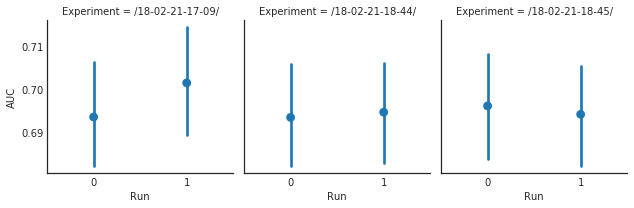

In [50]:
grid = seaborn.FacetGrid(data=raw_results, col='Experiment')
grid.map(seaborn.pointplot, 'Run', 'AUC', join=False)

## Performance Metrics with runs averaged

In [51]:
averaged_results = averaged_metrics(EXPERIMENTS_DIRS)

128 sequences ignored.
114 sequences ignored.
130 sequences ignored.
129 sequences ignored.
110 sequences ignored.
119 sequences ignored.


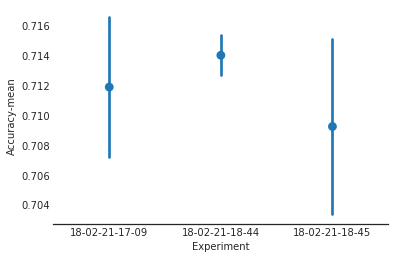

In [53]:
seaborn.pointplot(data=averaged_results, x='Experiment', y='Accuracy-mean', join=False)
seaborn.despine(left=True)

In [54]:
lala = averaged_results.groupby('Experiment')
lala.aggregate('mean')

,AUC-mean,RMSE-mean,APS-mean,Accuracy-mean,R2-mean,AUC-std,RMSE-std,APS-std,Accuracy-std,R2-std
Experiment,,,,,,,,,,
18-02-21-17-09,0.697559,0.419964,0.847015,0.711891,-0.193308,0.170231,0.141047,0.137808,0.158780,0.679924
18-02-21-18-44,0.694098,0.423634,0.844279,0.714017,-0.195071,0.160813,0.141915,0.140640,0.150654,0.662511
18-02-21-18-45,0.695194,0.427419,0.842834,0.709254,-0.191950,0.163821,0.134254,0.141385,0.152164,0.596051
